In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime 
%config InlineBackend.figure_format ='retina'

In [3]:
#/Users/thibaut/Library/Mobile Documents/com~apple~CloudDocs/Python/PythonTStest.csv

In [60]:
#TS = {1:12, 2:13, 3:14, 6:15, 9:16, 12:17, 18:18, 24:19, 36:20, 48:20, 96:20}
#TS = {1:[16.1,20,22.5], 2:[18,21,23], 3:[15,21.3,17], 4:[15.5,22,16.5], 5:[20,21.45,23], 6:[20,22,24], 9:[20,23,25], 12:[21,24,27]}
TS = {1:[15,19.5,20], 2:[15,20,20], 3:[15,20.5,20], 4:[15,20.3,21], 5:[15,20.1,23], 6:[15,20,24], 9:[16,20,25], 12:[16,20,25]}
df = pd.DataFrame(data=TS).T
df.index.rename('Months',inplace=True)
df.rename(columns={0:'1y Min',1:'Vol',2:'1y Max'},inplace=True)

In [61]:
days_in_month = 30
df['Tenor'] = df.index * days_in_month

In [62]:
df

,1y Min,Vol,1y Max,Tenor
Months,,,,
1,15.0,19.5,20.0,30
2,15.0,20.0,20.0,60
3,15.0,20.5,20.0,90
4,15.0,20.3,21.0,120
5,15.0,20.1,23.0,150
6,15.0,20.0,24.0,180
9,16.0,20.0,25.0,270
12,16.0,20.0,25.0,360


In [63]:
df['Fwd Vol'] = ((df['Tenor']*df['Vol']**2 - df['Tenor'].shift(1)*df['Vol'].shift(1)**2)/(df['Tenor']-df['Tenor'].shift(1)))**0.5
df['No Event Fwd Vol'] = df['Fwd Vol'].shift(1) + ((df['Tenor'] - df['Tenor'].shift(1))/(df['Tenor'].shift(-1) - df['Tenor'].shift(1))) * (df['Fwd Vol'].shift(-1) - df['Fwd Vol'])
df['No Event Variance']  = df['No Event Fwd Vol']**2 * (df['Tenor'] - df['Tenor'].shift(1) - 1)
df['Actual Period Variance'] = df['Fwd Vol']**2 * (df['Tenor'] - df['Tenor'].shift(1))
df['1d Variance'] = df['Actual Period Variance'] - df['No Event Variance']
df['1d Vol'] = np.sqrt(df['1d Variance'])
df['1d B/E Move'] = df['1d Vol']/np.sqrt(252)
df['Extra Days Variance'] = (df['Actual Period Variance']/df['No Event Fwd Vol']**2) - (df['Tenor'] - df['Tenor'].shift(1) - 1)

/Users/thibaut/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [66]:
df

,1y Min,Vol,1y Max,Tenor,Fwd Vol,No Event Fwd Vol,No Event Variance,Actual Period Variance,1d Variance,1d Vol,1d B/E Move,Extra Days Variance
Months,,,,,,,,,,,,
1,15.0,19.5,20.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,15.0,20.0,20.0,60,20.487801,NaN,NaN,12592.5,NaN,NaN,NaN,NaN
3,15.0,20.5,20.0,90,21.465088,19.599164,11139.689686,13822.5,2682.810314,51.795852,3.262832,6.984171
4,15.0,20.3,21.0,120,19.687813,21.260813,13108.642820,11628.3,-1480.342820,NaN,NaN,-3.274934
5,15.0,20.1,23.0,150,19.279263,19.794335,11362.655062,11150.7,-211.955062,NaN,NaN,-0.540956
6,15.0,20.0,24.0,180,19.492306,19.406187,10921.402641,11398.5,477.097359,21.842558,1.375952,1.266854
9,16.0,20.0,25.0,270,20.000000,19.492306,33815.550000,36000.0,2184.450000,46.738100,2.944224,5.749309
12,16.0,20.0,25.0,360,20.000000,NaN,NaN,36000.0,NaN,NaN,NaN,NaN


Text(0.5, 0.93, 'Index Implied Volatility, Forward Volatility and Extra Days Variance per Maturity')

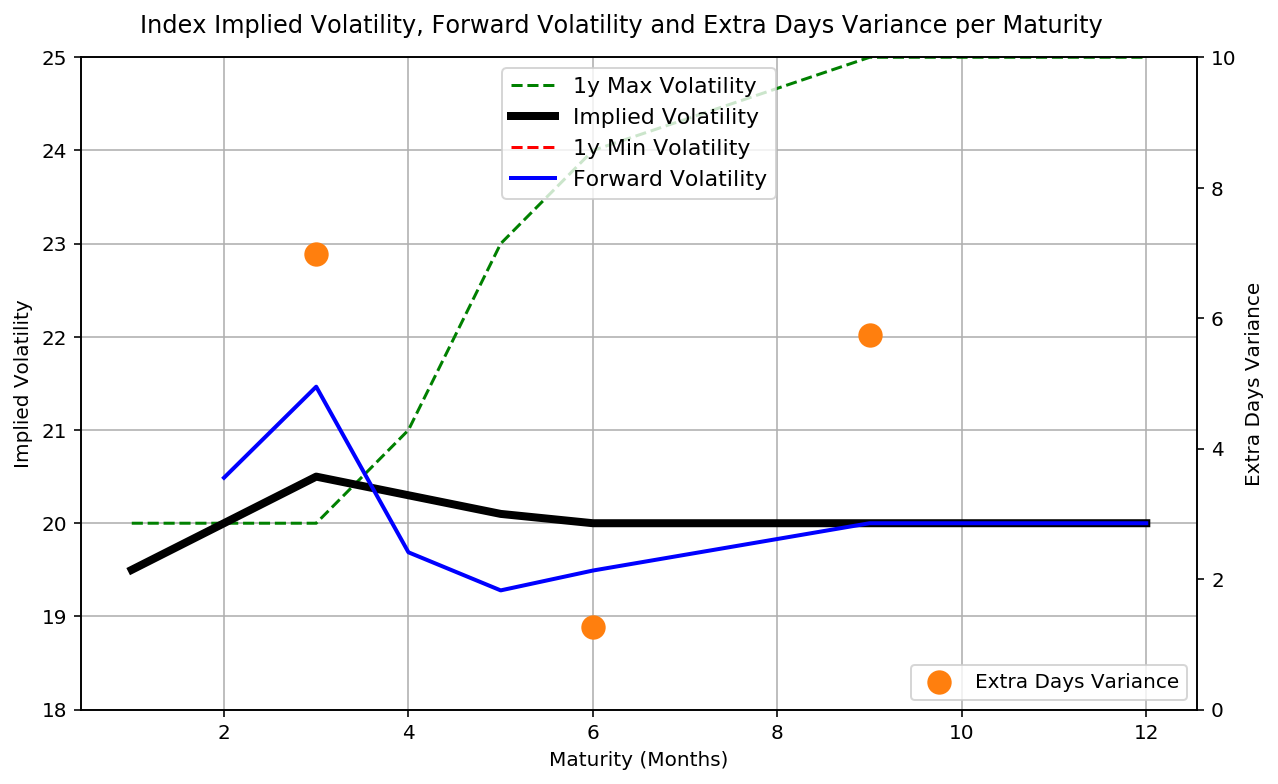

In [65]:
fig, ax  = plt.subplots(1,figsize=(10,6))
ax.grid()

sns.lineplot(data=df,x='Months',y='1y Max',ax=ax,label='1y Max Volatility',ls='--',color='green')
sns.lineplot(data=df,x='Months',y='Vol',ax=ax,label='Implied Volatility',lw=4,color='black')
sns.lineplot(data=df,x='Months',y='1y Min',ax=ax,label='1y Min Volatility',ls='--',color='red')
sns.lineplot(data=df,x='Months',y='Fwd Vol',ax=ax,label='Forward Volatility',color='blue',lw=2)
ax.legend(loc='upper center',fontsize=11)
#sns.lineplot(data=df,x='Months',y='No Event Fwd Vol',ax=ax)
ax2 = ax.twinx()
#sns.histplot(data=df,x='Months',y='Extra Days Variance',ax=ax2)
ax2.scatter(x=df.index,y=df['Extra Days Variance'],color='tab:orange',s=125,label='Extra Days Variance')
ax2.legend(loc='lower right')
#ax2.fill_between(df.index,df['Extra Days Variance'],0,color='red')
days_ylim_max = 10
ax.set_ylim([18,25])
ax2.set_ylim([0,days_ylim_max])
#ax2.axvline(x=df.index,ymax=(df['Extra Days Variance']/days_ylim_max))
#ax2.axvline(df.index,ymin=1,ymax=10)

ax.set_ylabel('Implied Volatility')
ax2.set_ylabel('Extra Days Variance')
ax.set_xlabel('Maturity (Months)')
fig.suptitle('Index Implied Volatility, Forward Volatility and Extra Days Variance per Maturity',y=0.93,fontsize=12)


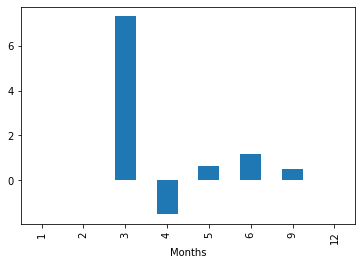

In [435]:
df['Extra Days Variance'].plot(kind='bar')

In [ ]:
#add column for number of days
#calculate forward volaitlity